# Pretraining results

last updated on 03-20-2022 by Cristobal Donoso

run the following code block once to change the root path

In [1]:
cd ../..

/home/cridonoso/Documents/astromer


In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

from core.astromer import ASTROMER
from core.training.scheduler import CustomSchedule
from core.data  import load_dataset, pretraining_pipeline
from core.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load testing dataset

In [4]:
data = './data/records/huge/test/'
time_steps = 200

dataset = load_dataset(data, shuffle=False, repeat=1)
dataset = pretraining_pipeline(dataset,
                               batch_size=256,
                               max_obs=time_steps,
                               msk_frac=0.5,
                               rnd_frac=0.2,
                               same_frac=0.2)

2022-03-22 10:19:51.541025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 10:19:51.541079: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 10:19:51.541105: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (appa): /proc/driver/nvidia/version does not exist
2022-03-22 10:19:51.542687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[INFO] Shuffling
[INFO] Pretraining mode. Random 200-len windows


## Loading ASTROMER pretrained model

In [5]:
exp_path = './runs/macho'

In [6]:
astromer = ASTROMER()

Now we'll load weights

In [7]:
astromer.load_weights(exp_path)

and compile the model

In [11]:
learning_rate = CustomSchedule(astromer.encoder.d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
astromer.compile(optimizer='adam')

In [12]:
rmse, r2 = astromer.evaluate(dataset)
print('rmse: {:.2f}'.format(rmse))
print('r2: {:.2f}'.format(r2))

2022-03-22 10:23:18.295779: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.
2022-03-22 10:23:18.297023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.
2022-03-22 10:23:18.301883: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.
2022-03-22 10:23:18.361424: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.
2022-03-22 10:23:18.368550: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.


598/598 [==============================] - 786s 1s/step - loss: 0.1658 - r2: 0.7469
rmse: 0.18
r2: 0.76


## Learning curves

In [13]:
train_metrics = get_metrics(os.path.join(exp_path, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(exp_path, 'logs', 'validation'))

Text(0.5, 1.0, 'Learning rate evolution')

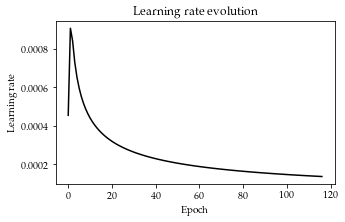

In [28]:
plt.figure(figsize=(5,3))
plt.plot(train_metrics['epoch_learning_rate'], color='k')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate evolution')

Text(0.5, 0, 'Number of Epochs')

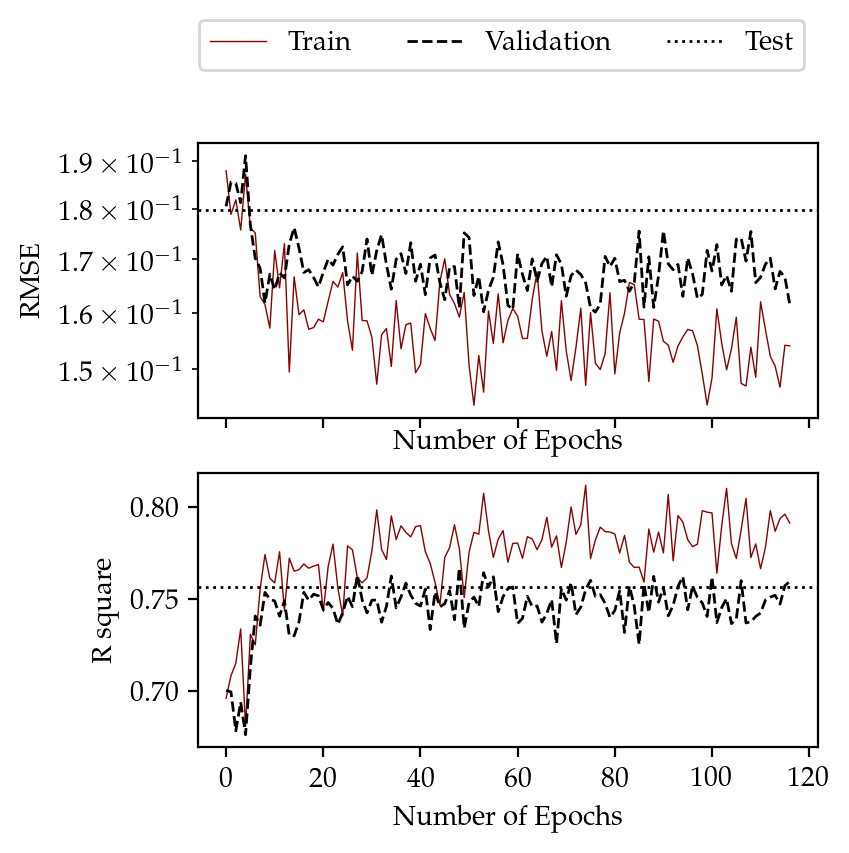

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(4,4), 
                         sharex=True, 
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.3}, 
                        dpi=200)

train_values = np.array(train_metrics['epoch_loss'])
vaild_values = np.array(val_metrics['epoch_loss'])

axes[0].plot(train_values, label='Train', color='darkred', linewidth=0.5)
axes[0].plot(vaild_values, label='Validation', color='k', linestyle='--', 
           linewidth=1)
axes[0].set_ylabel('RMSE')
axes[0].set_yscale('log')
axes[0].axhline(rmse, linestyle=':', linewidth=1, 
             color='k', label='Test')

axes[0].set_xlabel('Number of Epochs')

train_values = np.array(train_metrics['epoch_r2'])
vaild_values = np.array(val_metrics['epoch_r2'])

axes[1].plot(train_values, label='Train', color='darkred', linewidth=0.5)
axes[1].plot(vaild_values, label='Validation', color='k', linestyle='--', linewidth=1)
axes[1].set_ylabel('R square')
axes[1].axhline(r2, linestyle=':', linewidth=1, 
             color='k', label='Test')

axes[0].legend(ncol=3, bbox_to_anchor=(1, 1.5))
axes[1].set_xlabel('Number of Epochs')


## Visualizing predictions

/tmp/ipykernel_5673/2999738827.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


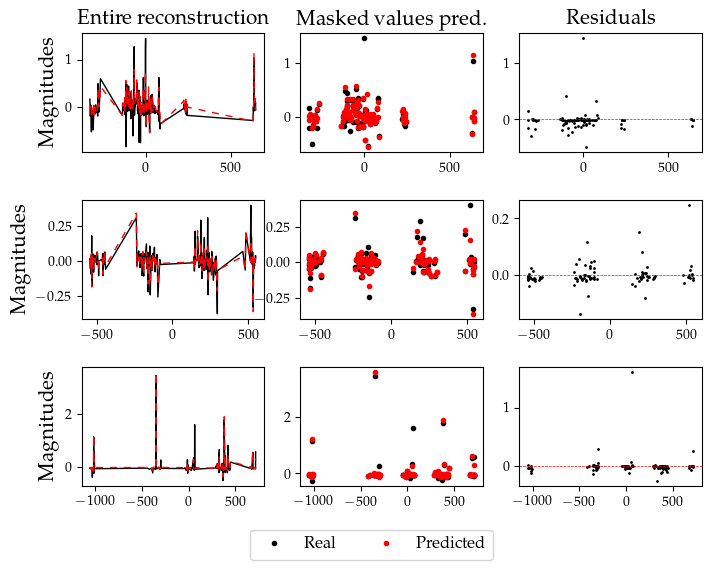

In [19]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=100, figsize=(8,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

for i, (x, (y, _, mask)) in enumerate(dataset.unbatch().batch(1).take(N)):
    
    y_pred = astromer(x)
    if i == 0:
        axes[i][0].set_title('Entire reconstruction', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][2].set_title('Residuals', fontsize=15)
        
        
    # ENTIRE LIGHT CURVE
    axes[i][0].plot(x['times'][0], y[0], marker='', linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(x['times'][0], y_pred[0], marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    # MASKED VALUES
    true_mask = tf.boolean_mask(y, mask)
    pred_mask = tf.boolean_mask(y_pred, mask)
    time_mask = tf.boolean_mask(x['times'], mask)
    
    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')
    
    # RESIDUALS
    residuals = true_mask - pred_mask
    axes[i][2].plot(time_mask, residuals, '.', markersize=2, color='k')
    axes[i][2].axhline(y=0., color='r', linestyle='--', linewidth=0.5)
    
axes[-1][1].legend(ncol=3, bbox_to_anchor = (1.1, -0.3), fontsize=12)
fig.tight_layout()

In [64]:
# fig.savefig('presentation/figures/pretraining.pdf', format='pdf', bbox_inches='tight') #transparent=True